<a id=top></a>
# Cross-Correlation

<h1>Learning Goals<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span><ul class="toc-item"><li><span><a href="#Import-Necessary-Packages" data-toc-modified-id="Import-Necessary-Packages-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import Necessary Packages</a></span></li><li><span><a href="#Collect-Data-Set-From-the-MAST-Archive-Using-Astroquery" data-toc-modified-id="Collect-Data-Set-From-the-MAST-Archive-Using-Astroquery-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Collect Data Set From the MAST Archive Using Astroquery</a></span></li></ul></li><li><span><a href="#_x1d-Spectra-of-the-Observations" data-toc-modified-id="_x1d-Spectra-of-the-Observations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>_x1d Spectra of the Observations</a></span></li><li><span><a href="#Cross-Correlation" data-toc-modified-id="Cross-Correlation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Cross-Correlation</a></span><ul class="toc-item"><li><span><a href="#Mean-Plate-Scale" data-toc-modified-id="Mean-Plate-Scale-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Mean Plate Scale</a></span></li><li><span><a href="#Lag-and-Cross-Correlation-Coefficient" data-toc-modified-id="Lag-and-Cross-Correlation-Coefficient-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Lag and Cross-Correlation Coefficient</a></span></li><li><span><a href="#Polynimial-Fitting-and-Zero-Point-Shift" data-toc-modified-id="Polynimial-Fitting-and-Zero-Point-Shift-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Polynimial Fitting and Zero Point Shift</a></span></li></ul></li><li><span><a href="#Recalibrate-Spectrum" data-toc-modified-id="Recalibrate-Spectrum-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Recalibrate Spectrum</a></span></li></ul></div>

## Introduction
If the acquisition of an observation fails, the zero point of the spectrum might be shifted because of the imprecise target positioning. However, if the target is visited by multiple observations, the shift can be corrected using cross-correlation. In this notebook, we will go through how to fix the shifted spectrum with cross-correlation.

### Import Necessary Packages
- `astropy.io fits` `astropy.table Table` for accessing FITS files
- `astroquery.mast Observations` for finding and downloading data from the [MAST](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html) archive
- `astropy.modeling fitting` `astropy.modeling.models Polynomial1D`for fitting polynomials
- `scipy.signal correlate` for performing cross-correlation
- `matplotlib` for plotting data
- `numpy` for handling array functions
- `stistools` for quick operations on STIS Data
- `os`,`shutil`,`pathlib` for managing system paths

In [1]:
from astropy.io import fits
from astroquery.mast import Observations

from astropy.modeling import fitting
from astropy.modeling.models import Polynomial1D

from scipy.signal import correlate
from scipy.signal import correlation_lags

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm

import numpy as np

import os,shutil
from pathlib import Path

import stistools

The following tasks in the stistools package can be run with TEAL:
   basic2d      calstis     ocrreject     wavecal        x1d          x2d


/Users/kding/miniconda3/envs/stis/lib/python3.7/site-packages/stsci/tools/nmpfit.py:8: UserWarning: NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.
  warnings.warn("NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.")
/Users/kding/miniconda3/envs/stis/lib/python3.7/site-packages/stsci/tools/gfit.py:18: UserWarning: GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it.Use astropy.modeling instead.
  warnings.warn("GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it."


### Collect Data Set From the MAST Archive Using Astroquery
In this notebook, we need to download to datasets and explore their correlation.

In [2]:
# Search target objscy by obs_id
target = Observations.query_criteria(obs_id=['odj101050','odj101060'])
# get a list of files assiciated with that target
target_list = Observations.get_product_list(target)
# Download only the SCIENCE fits files
Observations.download_products(target_list,productType="SCIENCE")

Local Path,Status,Message,URL
str47,str8,object,object
./mastDownload/HST/odj101050/odj101050_raw.fits,COMPLETE,None,None
./mastDownload/HST/odj101050/odj101050_x1d.fits,COMPLETE,None,None
./mastDownload/HST/odj101050/odj101050_x2d.fits,COMPLETE,None,None
./mastDownload/HST/odj101050/odj101050_flt.fits,COMPLETE,None,None
./mastDownload/HST/odj101060/odj101060_raw.fits,COMPLETE,None,None
./mastDownload/HST/odj101060/odj101060_x1d.fits,COMPLETE,None,None
./mastDownload/HST/odj101060/odj101060_x2d.fits,COMPLETE,None,None
./mastDownload/HST/odj101060/odj101060_flt.fits,COMPLETE,None,None


## _x1d Spectra of the Observations
In this notebook, the target was visited twice by the telescope. In the first visit, the target acquisition failed, leading to a shift in the wavelength zero point. In this section, we plot the spectra on the same figure to show the shift.

**We interpolate one of the spectra based on the other's wavelength so that the two spectra share the same wavelength array.**

Text(0, 0.5, 'Flux [ergs/s/cm$^2$/Å]')

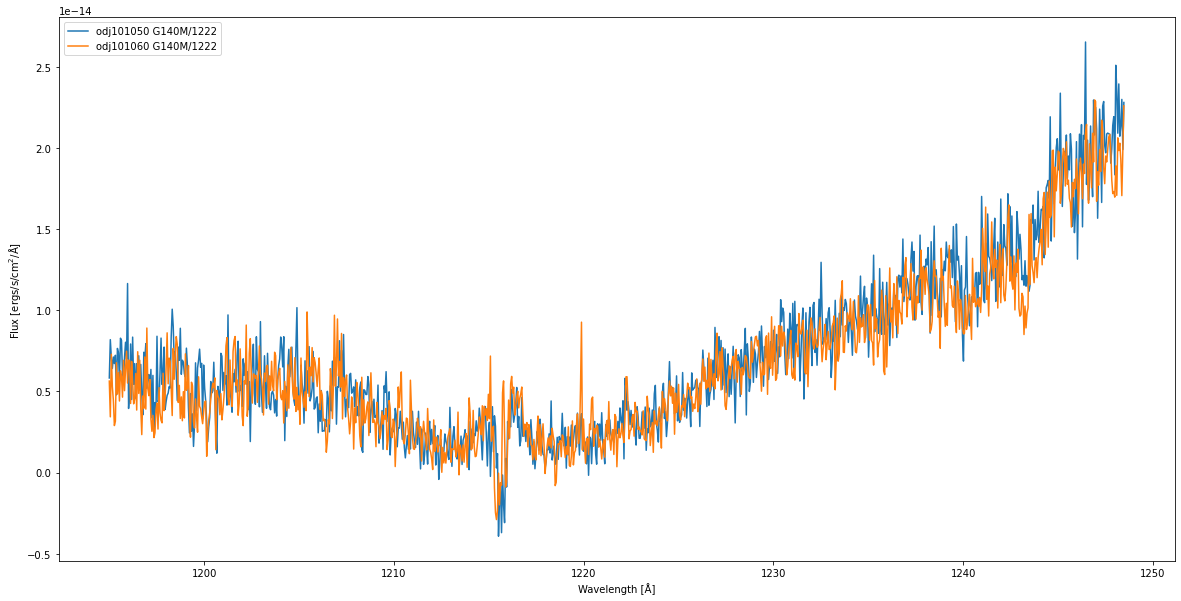

In [3]:
with fits.open("./mastDownload/HST/odj101050/odj101050_x1d.fits") as hdu1, fits.open("./mastDownload/HST/odj101060/odj101060_x1d.fits") as hdu2:
    wl = hdu1[1].data["WAVELENGTH"][0][10:-10]
    
    flux1 = hdu1[1].data["FLUX"][0][10:-10]
    flux2 = np.interp(wl,hdu2[1].data["WAVELENGTH"][0][10:-10],hdu2[1].data["FLUX"][0][10:-10])

fig = plt.figure(figsize=(20, 10))
plt.plot(wl,flux1,label="odj101050 G140M/1222")
plt.plot(wl,flux2,label="odj101060 G140M/1222")
plt.legend(loc="best")
plt.xlabel('Wavelength [' + chr(197) +']')
plt.ylabel("Flux [ergs/s/cm$^2$/" + chr(197) +"]")

## Cross-Correlation

### Mean Plate Scale
To perform cross-correlation, detemine the shift amount in pixels, and then convert it into wavelength, we first need to determine the mean plate scale, i.e., the mean differences of adjacent data points in the wavelength grid.

In [4]:
mean_plate_scale = np.mean(wl[1:]-wl[0:-1])
mean_plate_scale
print("The mean plate scale is {:.3f}".format(mean_plate_scale) + chr(197)+"/pixel")

The mean plate scale is 0.053Å/pixel


### Lag and Cross-Correlation Coefficient

The lag is the displacement (in pixels) in the lagged spectrum. If the lag is 0, the spectra are aligned and not shifted.


The cross-correlation coefficient decodes how similar two spectra are. The cross-correlation coefficient takes values from -1 to 1: if it's positive, the 2 spectra are positively correlated, if it's negative, the 2 spectra are negatively correlated. 

The cross-correlation algorithm shifts one of the input spectra according the the lags, and computes the cross-correlation coefficient for each lag. Then we take the lag with the maximum cross-coefficient and compute the corresponding displacement in wavelength space.

In general, the cross-correlation can be written as:

<p style="text-align: center;">$C_{xy}[k]=\sum_n x[n] y[n+k]$</p>

in which k is the lag, C is the cross-correlation coefficient, and x and y are the input spectra.

**Normalization of the input spectra is required to ensure the cross-correlation coefficient is in the [-1,1] range.**

In [5]:
def cross_correlate(a, b):
    assert len(a) == len(b), 'Arrays must be same size'
    
    # Normalize inputs:
    aa = a - a.mean()
    aa /= aa.std()
    bb = b - b.mean()
    bb /= bb.std()
    
    # find the cross-correlation coefficient
    cc = correlate(aa, bb, mode='same') / float(len(a))
    # centered at the median of len(a)
    lag = correlation_lags(len(aa), len(bb),mode="same")
        
    return lag, cc

In [6]:
lag,cc = cross_correlate(flux1,flux2)

### Polynimial Fitting and Zero Point Shift
After we get the lag and cross-correlation coefficient, we can determine the zero point shift by finding the lag with the maximum cross-correlation coefficient. However, since we only have discrete pixels shifts, we will fit a quadratic curve near the peak, get a fractional pixel shift, and find the maxima of the quadratic curve as the zero point shift. The zero point shift is shown as the green vertical line in the plot.

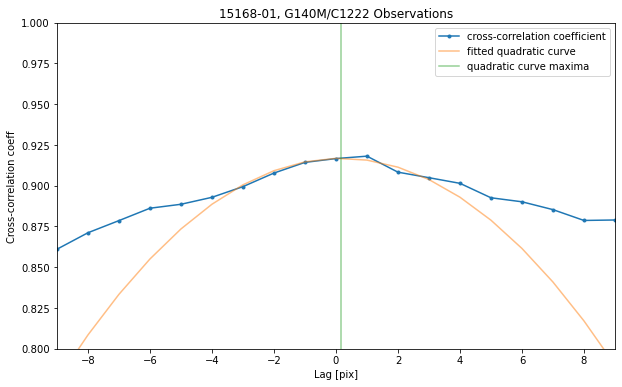

In [7]:
fig = plt.figure(figsize=(10, 6))
lag,cc = cross_correlate(flux1,flux2)
plt.plot(lag,cc,'.-',label="cross-correlation coefficient")

# fit quadratic near the peak to find the pixel shift
fitter = fitting.LinearLSQFitter()
# get the 5 points near the peak
low, hi = np.argmax(cc) - 2, np.argmax(cc) + 2 + 1
fit = fitter(Polynomial1D(degree=2),x=lag[low:hi],y=cc[low:hi])
x_c = np.arange(-10,10)
plt.plot(x_c, fit(x_c), alpha=0.5,label="fitted quadratic curve")
# finding the maxima
shift = -fit.parameters[1] / (2. * fit.parameters[2])
plt.plot([shift,shift],[0,1],alpha=0.5,label="quadratic curve maxima")

plt.xlim(-9,9)
plt.ylim(0.8,1.)
plt.xlabel('Lag [pix]')
plt.ylabel('Cross-correlation coeff')
plt.title('15168-01, G140M/C1222 Observations')
plt.legend(loc="best")

Convert the lag back into zero point shift in wavelength space:

In [8]:
print("Shift between the G140M/c1222 observations is {:.3f} pix = {:.3f}".format(shift, shift * mean_plate_scale) + chr(197) )

Shift between the G140M/c1222 observations is 0.166 pix = 0.009Å


## Recalibrate Spectrum
After we determine the wavelength zero point shift, we can use the value to recalibrate the spectrum.

In the Calstis pipline, 'WAVECORR' calibration step determines the spectral shift values, and writes the keyword values SHIFTA1, SHIFTA2 for the spectral and spatial shifts, respectively, to the science header. To apply the spectral shift from the cross-correlation, we get the SHIFTA1, SHIFTA2 keywords from the _flt fits file, add the shift (in pixel space) to SHIFTA1, and write the updated keywords to the _raw fits file.

In [9]:
# get SHIFTA1, SHIFTA2 keywords from the first science extension
SHIFTA1 = fits.getheader("./mastDownload/HST/odj101050/odj101050_flt.fits",1)["SHIFTA1"]
SHIFTA2 = fits.getheader("./mastDownload/HST/odj101050/odj101050_flt.fits",1)["SHIFTA2"]
# update SHIFTA1 (only in the spectral direction)
SHIFTA1 += shift
# update the the SHIFTA1, SHIFTA2 keywords in the _raw fits file first science extension
fits.setval("./mastDownload/HST/odj101050/odj101050_raw.fits","SHIFTA1",value=SHIFTA1,ext=1)
fits.setval("./mastDownload/HST/odj101050/odj101050_raw.fits","SHIFTA2",value=SHIFTA2,ext=1)

Then we need to turn the 'WAVECORR' calibration switch to "omit" so that the Calstis calibration pipline takes our passed value instead of the wavecal returned value as the wavelength zero point shift.

In [10]:
fits.setval("./mastDownload/HST/odj101050/odj101050_raw.fits","WAVECORR",value='OMIT',ext=0)
assert fits.getheader("./mastDownload/HST/odj101050/odj101050_raw.fits",0)["WAVECORR"] == 'OMIT'

Recalibrate the spectrum using the Calstis pipline. We create a new folder called 'Recalibration' to store the recalibrated files. For more information on the Calstis pipline, see: [STIS Calibration](https://hst-docs.stsci.edu/stisdhb/chapter-3-stis-calibration), [calstis](https://stistools.readthedocs.io/en/latest/calstis.html).

In [11]:
# Create and clean "./Recalibration" directory for saving new files
if os.path.exists('./Recalibration'):
    shutil.rmtree('./Recalibration')
Path('./Recalibration').mkdir(exist_ok=True)
# Recalibration
res = stistools.calstis.calstis("./mastDownload/HST/odj101050/odj101050_raw.fits",verbose=False,outroot='./Recalibration/')
# calstis returns 0 if calibration completes; if not, raise assertion error
assert res == 0, f'CalSTIS exited with an error:  {res}'


*** CALSTIS-0 -- Version 3.4.2 (19-Jan-2018) ***
Begin    12-Dec-2022 20:19:50 EST

Input    ./mastDownload/HST/odj101050/odj101050_raw.fits
Outroot  ./Recalibration/odj101050_raw.fits

*** CALSTIS-1 -- Version 3.4.2 (19-Jan-2018) ***
Begin    12-Dec-2022 20:19:52 EST
Input    ./mastDownload/HST/odj101050/odj101050_raw.fits
Output   ./Recalibration/odj101050_flt.fits
OBSMODE  ACCUM
APERTURE 52X0.2
OPT_ELEM G140M
DETECTOR FUV-MAMA

Imset 1  Begin 20:19:52 EST

DQICORR  PERFORM
DQITAB   oref$uce15153o_bpx.fits
DQITAB   PEDIGREE=GROUND
DQITAB   DESCRIP =New BPIXTAB with opt_elem column and correct repeller wire flag----
DQICORR  COMPLETE
         Uncertainty array initialized.

LORSCORR PERFORM
LORSCORR COMPLETE

GLINCORR PERFORM
LFLGCORR PERFORM
MLINTAB  oref$j9r16559o_lin.fits
MLINTAB  PEDIGREE=GROUND
MLINTAB  DESCRIP =T. Danks gathered Info
MLINTAB  DESCRIP =T. Danks Gathered Info
GLINCORR COMPLETE
LFLGCORR COMPLETE

DARKCORR PERFORM
DARKFILE oref$q591955ro_drk.fits
DARKFILE PEDIGREE=

Plot the original and recalibrated spectrum:

Text(0, 0.5, 'Flux [ergs/s/cm$^2$/Å]')

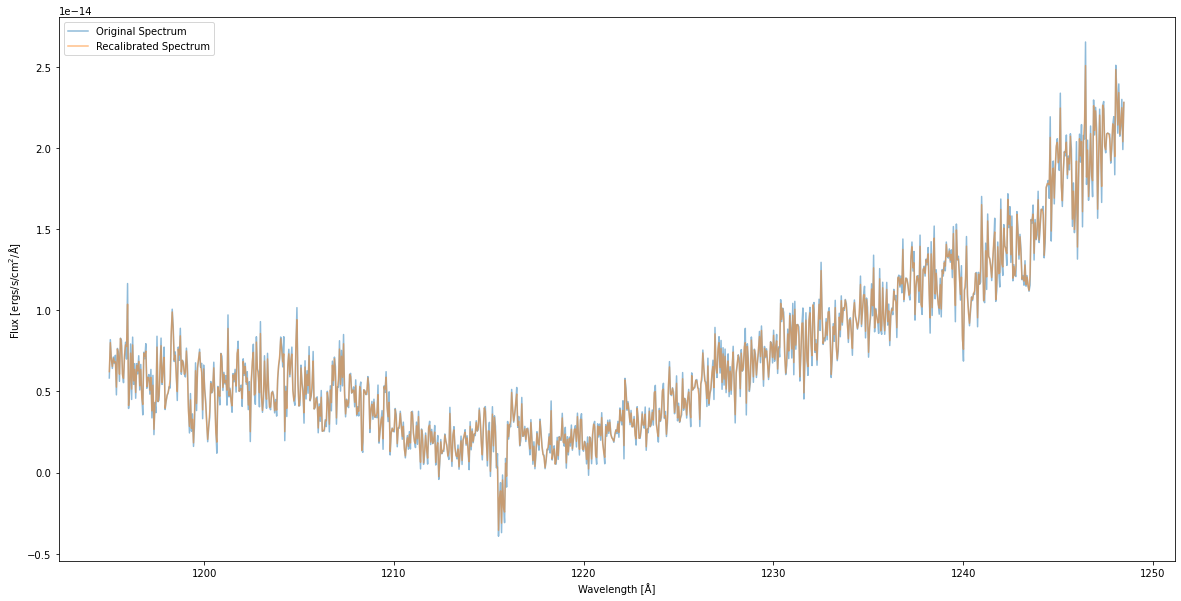

In [12]:
with fits.open("./mastDownload/HST/odj101050/odj101050_x1d.fits") as hdu1, fits.open("./Recalibration/odj101050_x1d.fits") as hdu2:
    wl = hdu1[1].data["WAVELENGTH"][0][10:-10]
    
    flux1 = hdu1[1].data["FLUX"][0][10:-10]
    flux2 = np.interp(wl,hdu2[1].data["WAVELENGTH"][0][10:-10],hdu2[1].data["FLUX"][0][10:-10])

fig = plt.figure(figsize=(20, 10))
plt.plot(wl,flux1,label="Original Spectrum",alpha=0.5)
plt.plot(wl,flux2,label="Recalibrated Spectrum",alpha=0.5)
plt.legend(loc="best")
plt.xlabel('Wavelength [' + chr(197) +']')
plt.ylabel("Flux [ergs/s/cm$^2$/" + chr(197) +"]")


---
## About this Notebook <a class="tocSkip">
**Author:** [Keyi Ding](kding@stsci.edu)

**Updated On:** 2022-12-09


> *This tutorial was generated to be in compliance with the [STScI style guides](https://github.com/spacetelescope/style-guides) and would like to cite the [Jupyter guide](https://github.com/spacetelescope/style-guides/blob/master/templates/example_notebook.ipynb) in particular.*
## Citations <a class="tocSkip">

If you use `astropy`, `matplotlib`, `astroquery`, or `numpy` for published research, please cite the
authors. Follow these links for more information about citations:

* [Citing `astropy`/`numpy`/`matplotlib`](https://www.scipy.org/citing.html)
* [Citing `astroquery`](https://astroquery.readthedocs.io/en/latest/)

---

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 